<div style="text-align: left; background-color:#E9F7EF; font-family:Arial; color:#526085; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 58px;border-style: solid;border-color: dark green;">Lab 05 - Support Vector Machine</div>
<div style="text-align: left; background-color:#fadefc; font-family: Arial; color:#551184; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 18px">| LẠI TOÀN THẮNG - 20280083 - CA 2|</div>


> Description churn_rate_prediction.csv
-	Apply all knowledge and techniques that you have learned for this
-	You must organize your notebook based on the Homework
-	Should not drop NA and missing value


In [17]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(color_codes=True)
%matplotlib inline


# **Load Dataset**

In [18]:
df = pd.read_csv("C:\\Users\\laito\\OneDrive - VNU-HCMUS\\Jupyter Hub\\KHDL\\KHDL-MACHINE LEARNING\\Labs\\Week 06\\churn_rate_prediction.csv")
df.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


# **Data Analysis**
> Analyze and Preprocess data - Check if the dataset has missing values or has any other problem.

In [19]:
df.dtypes

customer_id                      object
Name                             object
age                               int64
gender                           object
security_no                      object
region_category                  object
membership_category              object
joining_date                     object
joined_through_referral          object
referral_id                      object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
last_visit_time                  object
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days         object
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
feedback                         object
churn_risk_score                  int64


In [20]:
# from pandas_profiling import ProfileReport
# ProfileReport(df)

> Note: 
* According to Profile Report, some features has missing values as below
	* `region_category` has `5428` missing values - use `mode imputation`
	* `preferred_offer_types` has `288` missing values - `Handle: drop rows with nan`
	* `points_in_wallet` has `3443` missing value and high correlation - `mean imputation`
* Beside that, còn một số ô mang dữ liệu không ý nghĩa như some cells have meaningless data
	* `joined_through_referral` values (?)
	* `referral_id` (17846  values xxxxxxxx), 
	* `medium_of_operation` (?)
	* `avg_frequency_login_days` has value is 3522 `Error` and `imbalance`
	* `age` has data type like Unknown

# **Data Preprocessing**

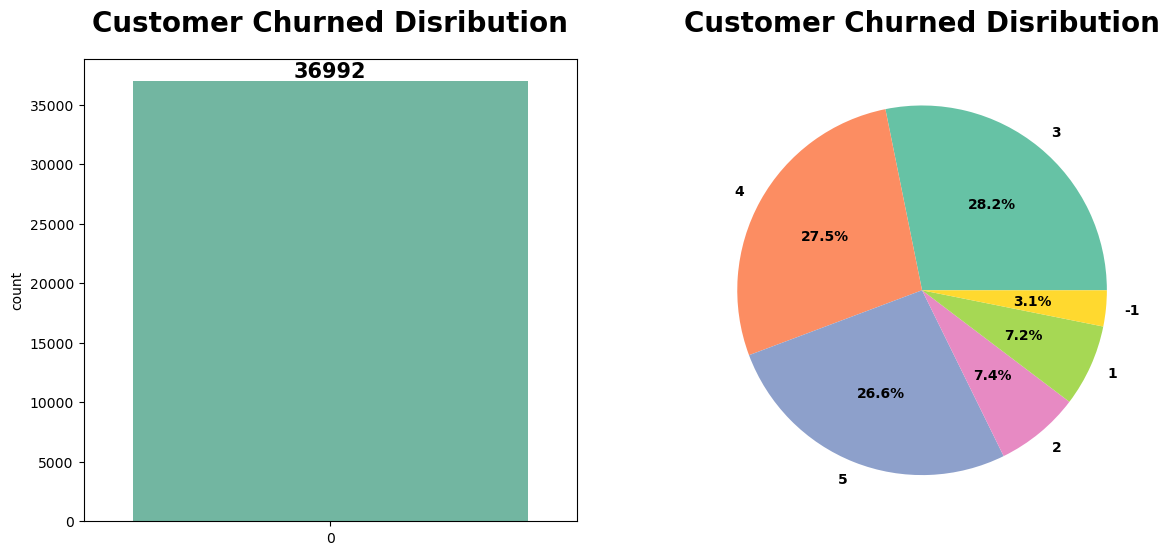

In [21]:
count = df["churn_risk_score"].value_counts()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
ax=sns.countplot(df["churn_risk_score"],palette="Set2")
ax.bar_label(ax.containers[0],fontweight="black",size=15)
plt.title("Customer Churned Disribution",fontweight="black",size=20,pad=20)

plt.subplot(1,2,2)
plt.pie(count.values, labels=count.index, autopct="%1.1f%%",colors=sns.set_palette("Set2"),
        textprops={"fontweight":"black"})
plt.title("Customer Churned Disribution",fontweight="black",size=20,pad=20)
plt.show()

</div><div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown>📊 Inference:</font></h3>

* There is **huge class-imbalance** which can lead to **bias in model performance.**
* So to **overcome** this **class-imbalance** we have to use **over-sampling technique** from **SMOTE**.

What is negative churn?

https://www.paddle.com/resources/negative-churn

Give u an example like this. Let's say you are running a software company that offers a subscription plan for 100$/month. At the beginning of the month, you have 100 customers and $10,000 revenue.

Throughout the month, know customer churn. 5 customers leave and cancel their subscriptions, resulting in a loss of $500. However, 10 existing customer upgrade their plans and you receive $1000

This represents growth from your existing customers and contributes to overall revenue expansion without acquiring new customers.

In this dataset, what is the reason?
> There is a huge difference between some of the classes in the target(churn_risk_score) column.(-1,1 and 2 are quite less as compared 3,4,5). We will handle it when creating the model

In [22]:
print('Total', df.shape[0], 'samples')
df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})

Total 36992 samples


,Total No. of Missing Values
customer_id,0
Name,0
age,0
gender,0
security_no,0
region_category,5428
membership_category,0
joining_date,0
joined_through_referral,0
referral_id,0


In [23]:
df[df.duplicated()]

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score


In [24]:
df.describe(include="object").T

,count,unique,top,freq
customer_id,36992,36992,fffe4300490044003600300030003800,1
Name,36992,36992,Pattie Morrisey,1
gender,36992,3,F,18490
security_no,36992,36992,XW0DQ7H,1
region_category,31564,3,Town,14128
membership_category,36992,6,Basic Membership,7724
joining_date,36992,1096,2015-06-02,55
joined_through_referral,36992,3,No,15839
referral_id,36992,11359,xxxxxxxx,17846
preferred_offer_types,36704,3,Gift Vouchers/Coupons,12349


> Note: 
* Drop những cột feature không mang bất cứ insight nào để dự đoán churn risk như `customer_id`, `Name`, `security_no`, `joining_date`, `referral_id`, `last_visit_time`


In [25]:
from sklearn.impute import SimpleImputer
def preprocessing_data(df):
    """
    Preprocess your data (eg. Drop null datapoints or fill missing data)
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    # Todo: preprocess data
    
    # Drop unnecessary column
    df = df.drop(columns=['customer_id', 'Name', 'security_no', 'referral_id', 'days_since_last_login', 'joining_date', 'last_visit_time'], axis = 1)
    
    df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'], errors='coerce')
    # df['churn_risk_score'] = df['churn_risk_score'].astype('category')
    
    # Fill nan in preferred_offer_types by 
    imputer_mode = SimpleImputer(strategy='most_frequent')
    df[['region_category']] = imputer_mode.fit_transform(df[['region_category']])
    df[['region_category']] = imputer_mode.fit_transform(df[['region_category']])
    df[['preferred_offer_types']] = imputer_mode.fit_transform(df[['preferred_offer_types']])
    
    # Fill nan by mean of points in wallet
    imputer_mean = SimpleImputer(strategy = 'mean')
    df[['points_in_wallet']] = imputer_mean.fit_transform(df[['points_in_wallet']])
    df[['avg_frequency_login_days']] = imputer_mean.fit_transform(df[['avg_frequency_login_days']])
    
    return df

In [26]:
# no effect to the original data
df = preprocessing_data(df.copy())

joined_through_referral: join by invitation by friends or family



# **Exploratory Data Analysis**

In [27]:
categorical_cols = [feature for feature in df.columns if df[feature].dtype == 'O']
numerical_cols = [feature for feature in df.columns if df[feature].dtype != 'O']

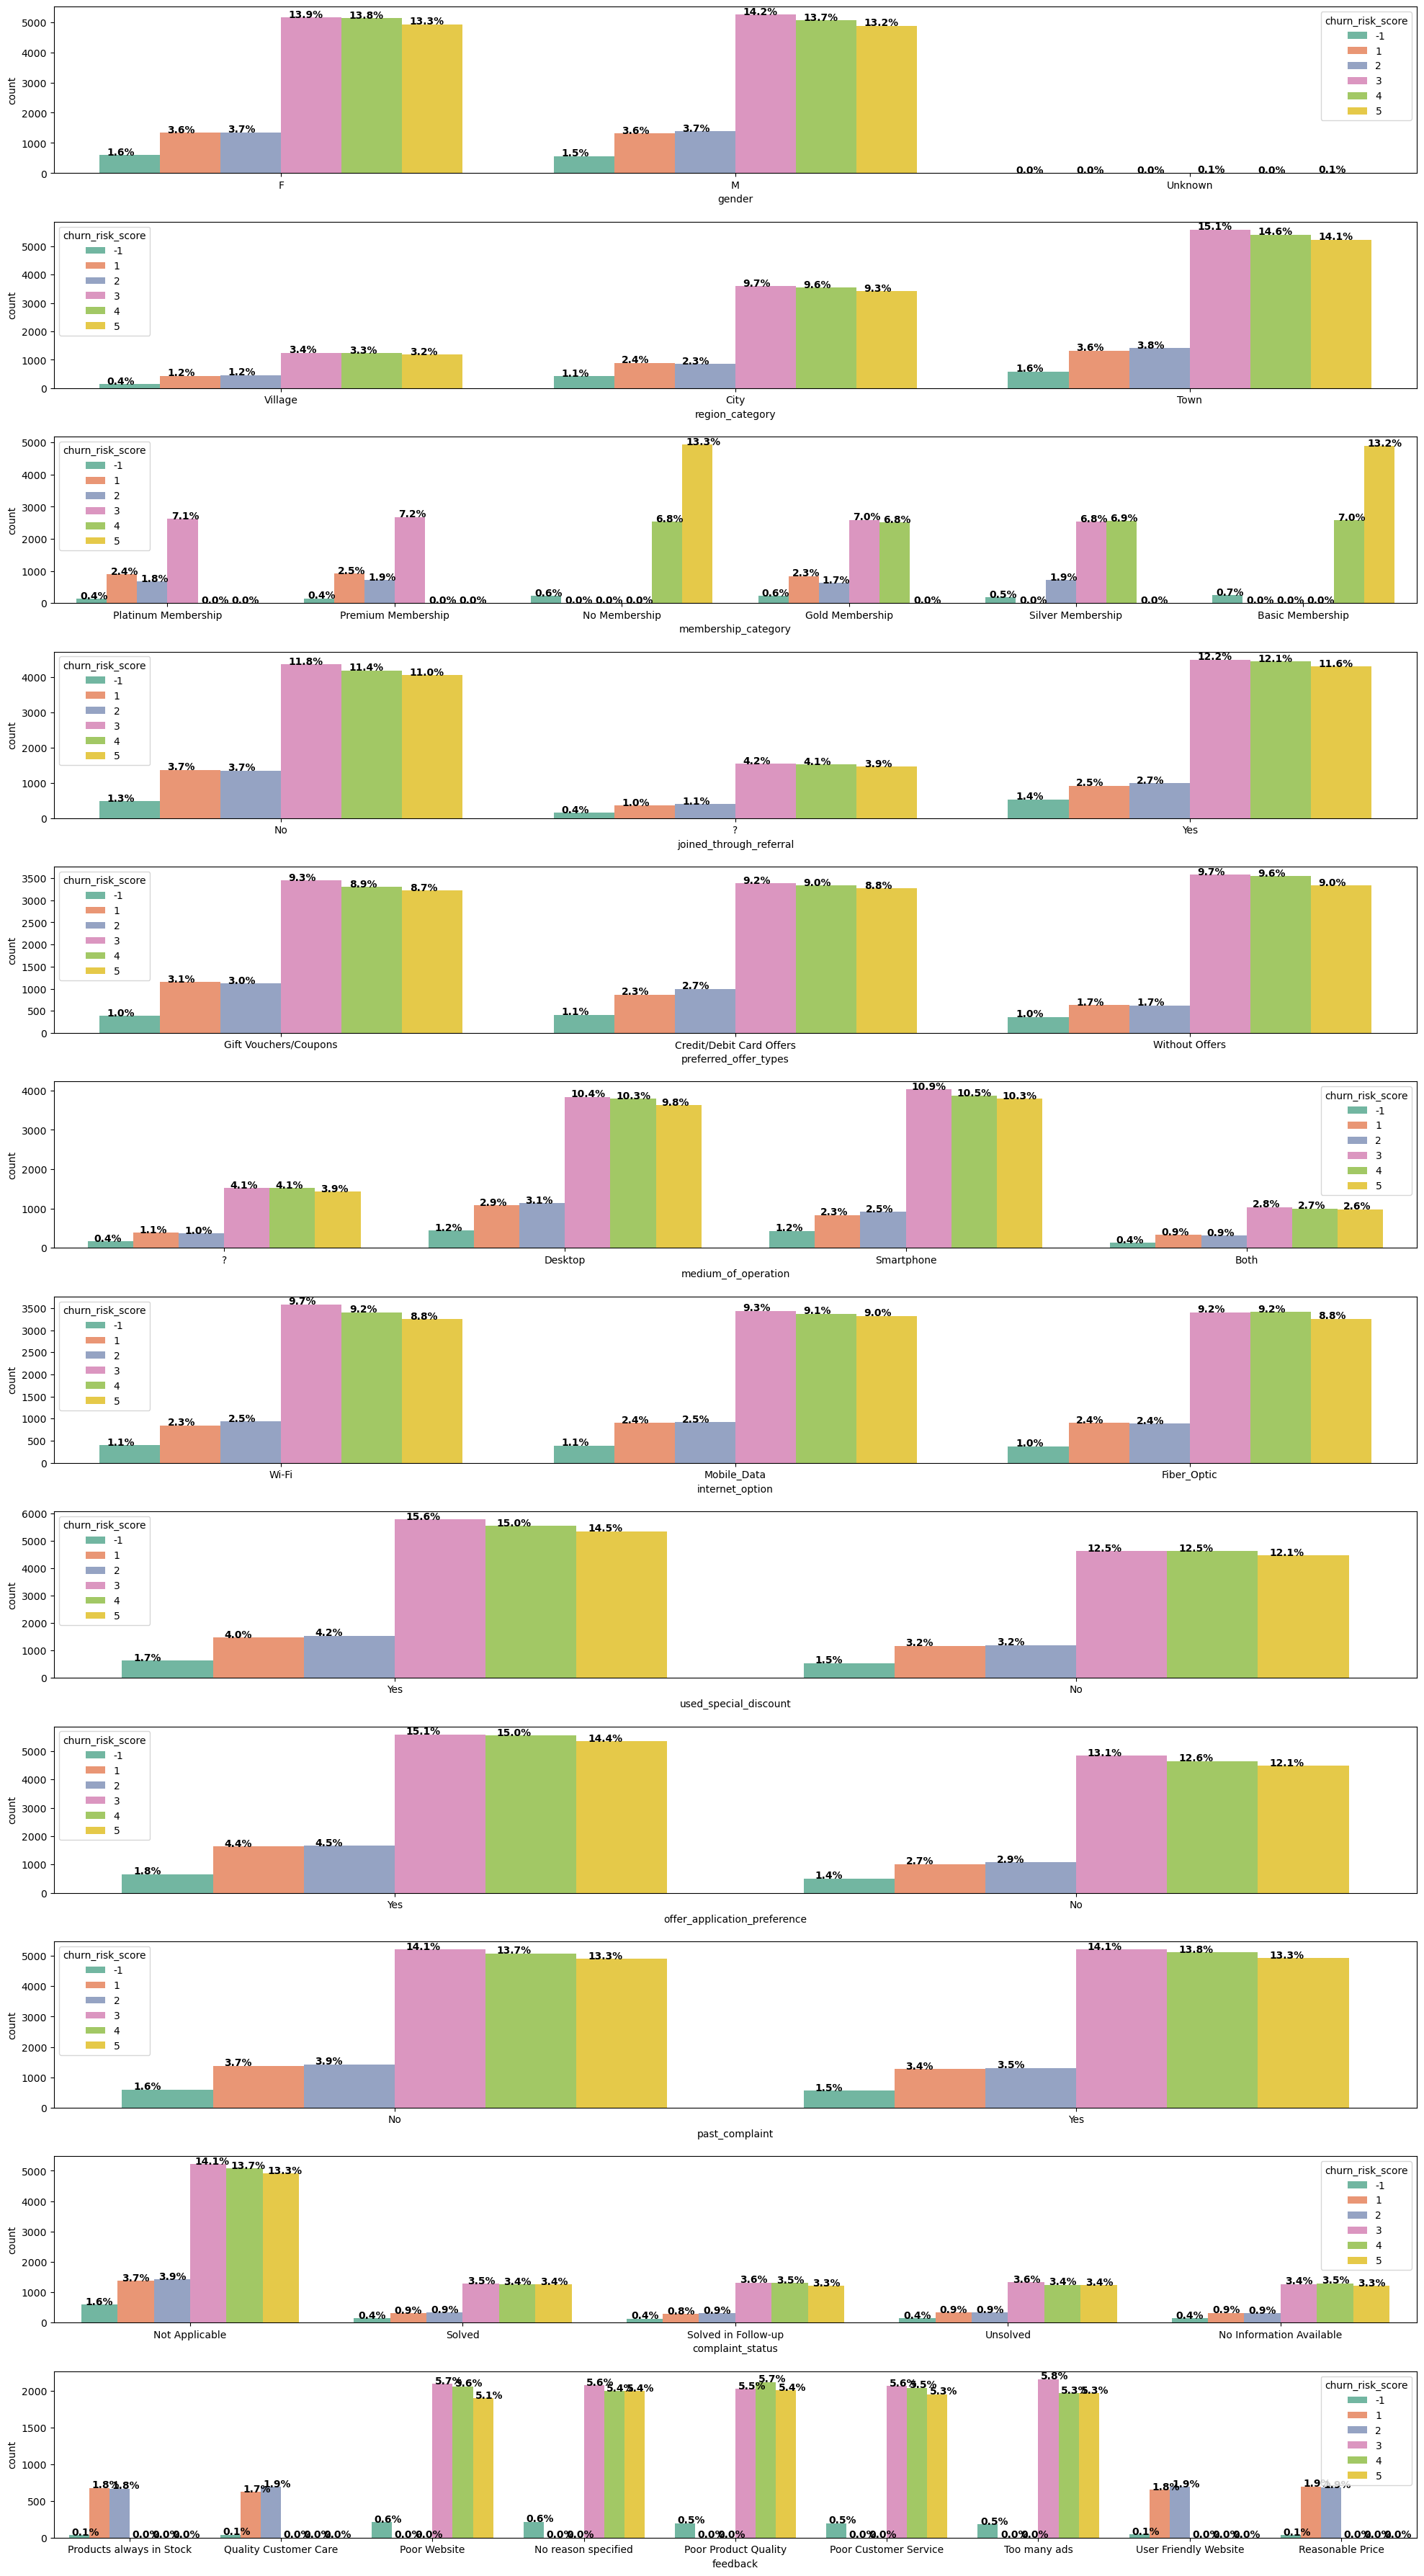

In [28]:
fig, axes = plt.subplots(len(categorical_cols), 1 , figsize = (20, 3 * len(categorical_cols)), sharex = False, sharey = False)
for i, column in enumerate(categorical_cols):
  ax = sns.countplot(x=column, data=df, ax=axes[i], hue="churn_risk_score", palette="Set2")
  for value in ax.patches:
        percentage = "{:.1f}%".format(100*value.get_height()/len(df[column]))
        x = value.get_x() + value.get_width() / 2 - 0.05
        y = value.get_y() + value.get_height()
        ax.annotate(percentage, (x,y), fontweight="black",size=10)
plt.tight_layout(pad=1.5)
plt.show()

* Membership: The ratio of customers have no membership or low membership, will have a low churn rate score 
* joined_through_referral: what is `?`. Maybe they found it by coincidence and stick to using it

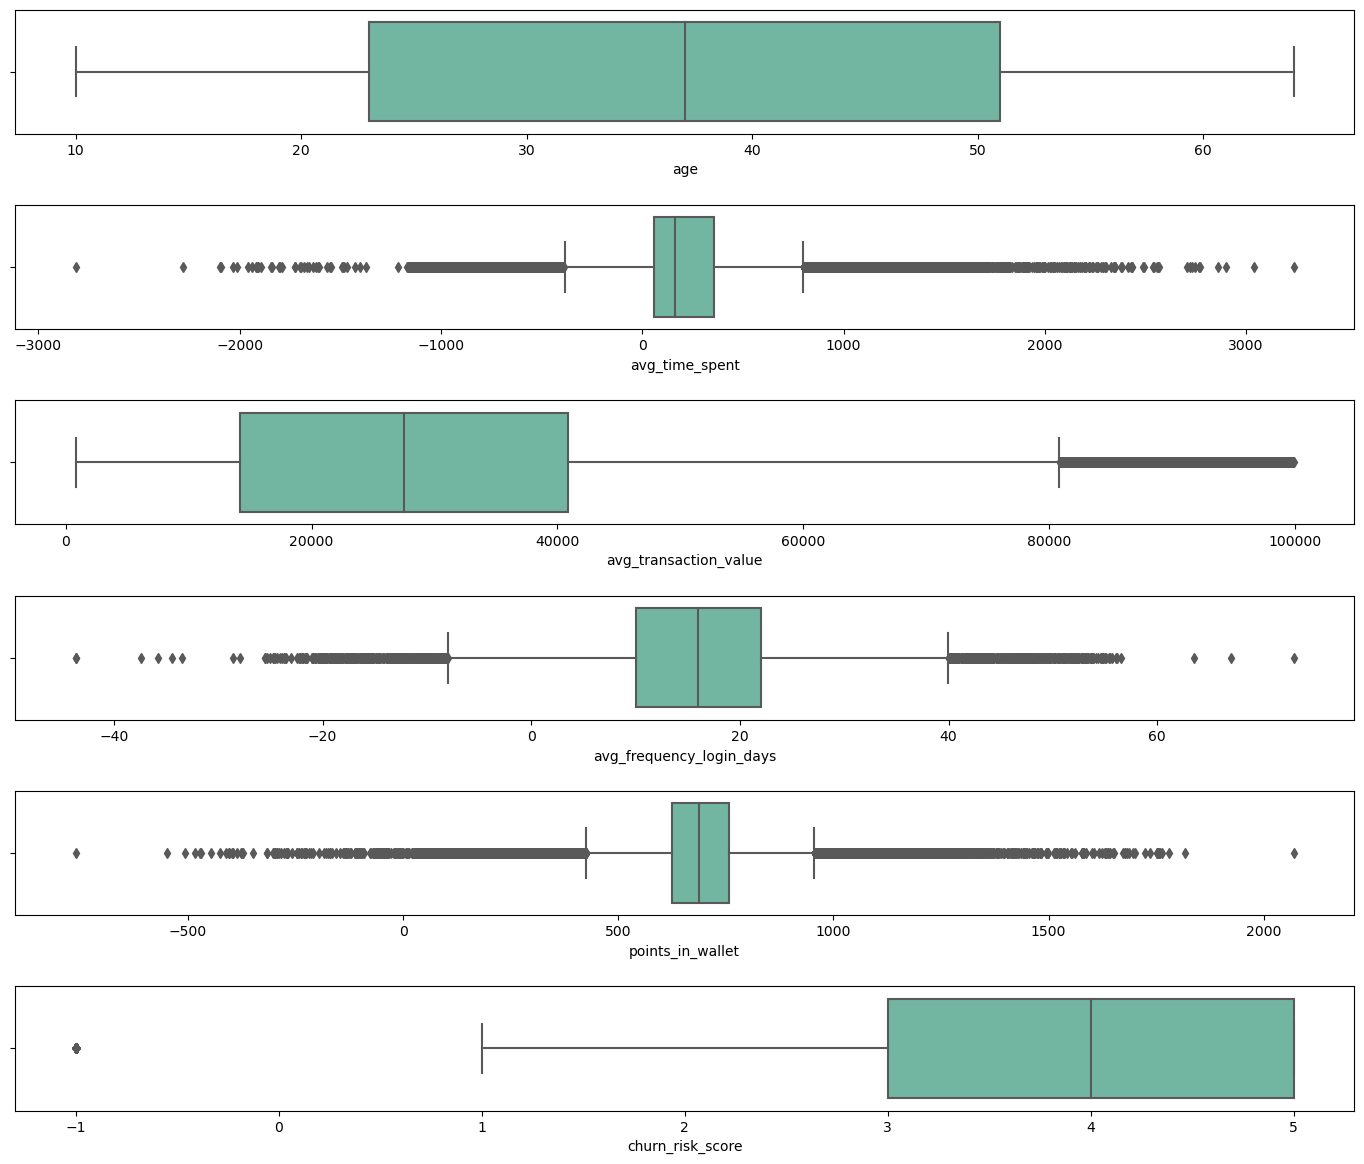

In [29]:
fig, axes=plt.subplots(len(numerical_cols), 1, figsize=(14, 2*len(numerical_cols)),sharex=False,sharey=False)

for i, column in enumerate(numerical_cols):
    sns.boxplot(x=column,data=df,palette='Set2',ax=axes[i])
plt.tight_layout(pad=2.0)

> Why so many negative numbers in features which is average of time. It will be make sense if the number more than 0. Damnn

In [82]:
def numerical_plot(column, df):
    plt.figure(figsize=(13,6))
    plt.subplot(1,2,1)
    # sns.histplot(data = df, x = column, hue = 'churn_risk_score', kde = True, palette = 'Set2')
    sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)
    plt.title(f"Distribution of {column} by Churn Status",fontweight="black",pad=20,size=11)
    
    plt.subplot(1,2,2)
    sns.boxenplot(data = df, x = column)
    plt.title(f"Distribution of {column} by Churn Status",fontweight="black",pad=20,size=11)
    plt.tight_layout()
    plt.show()

In [33]:
numerical_cols

['age',
 'avg_time_spent',
 'avg_transaction_value',
 'avg_frequency_login_days',
 'points_in_wallet',
 'churn_risk_score']

C:\Users\laito\AppData\Local\Temp\ipykernel_10780\1807629984.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)


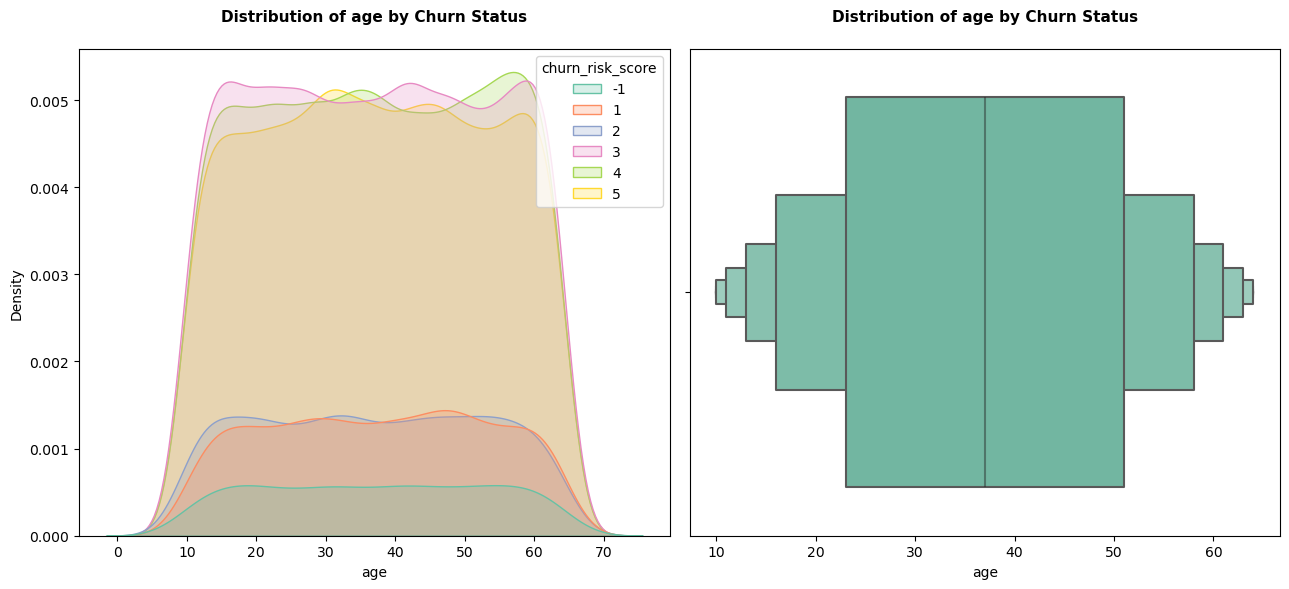

C:\Users\laito\AppData\Local\Temp\ipykernel_10780\1807629984.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)


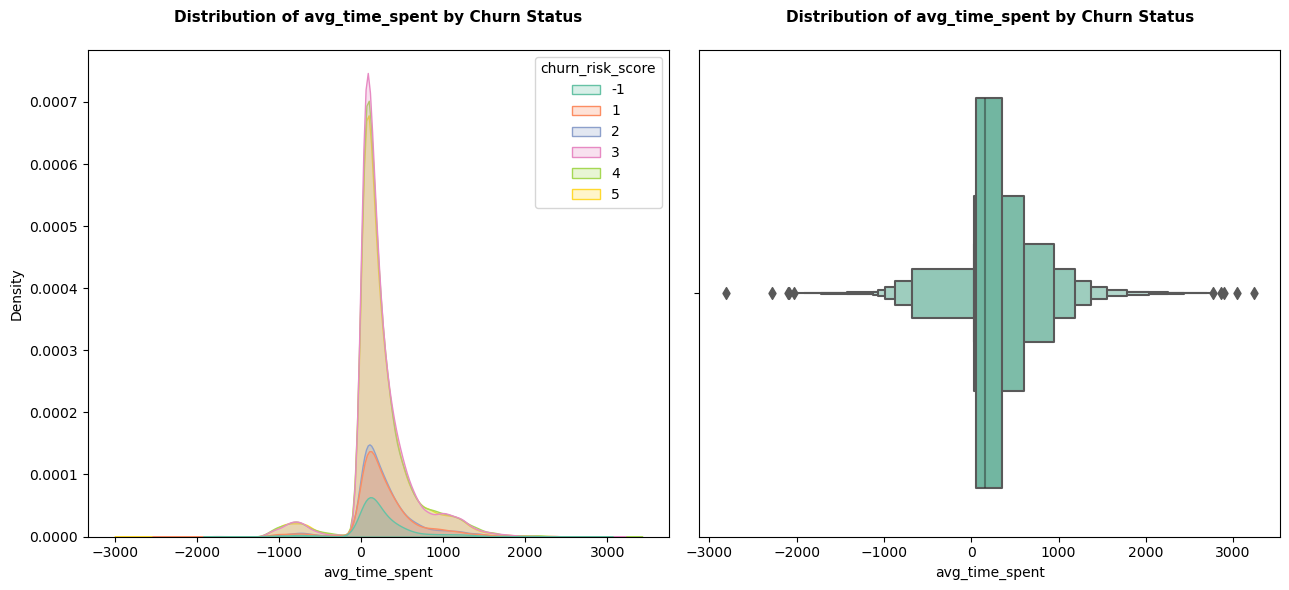

C:\Users\laito\AppData\Local\Temp\ipykernel_10780\1807629984.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)


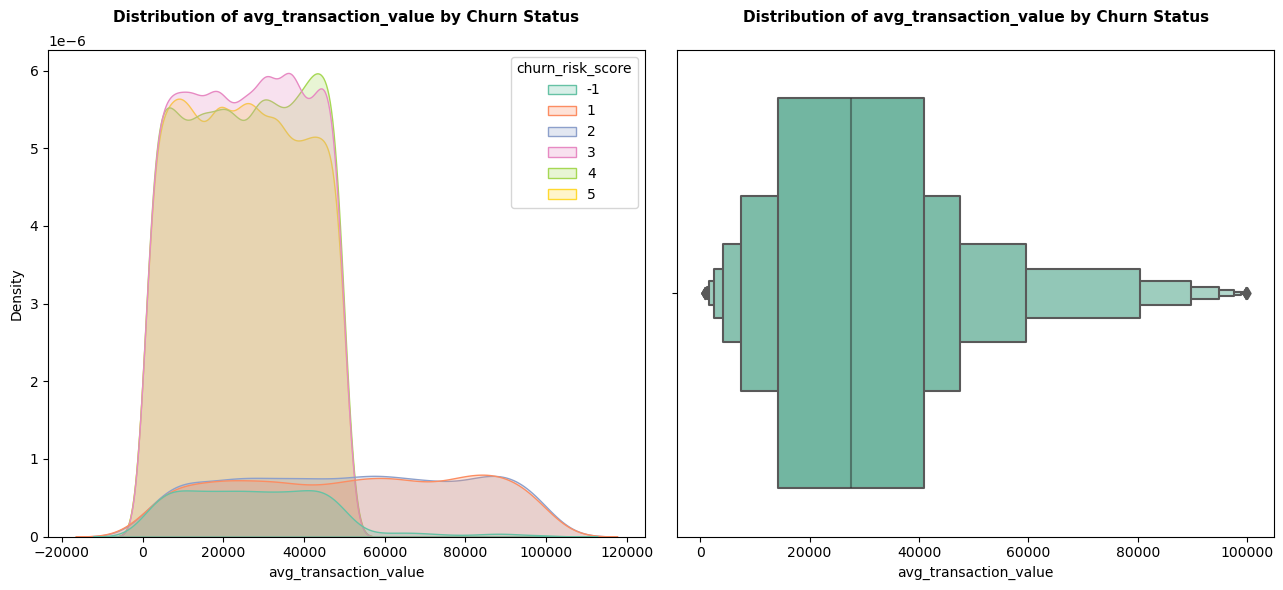

C:\Users\laito\AppData\Local\Temp\ipykernel_10780\1807629984.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)


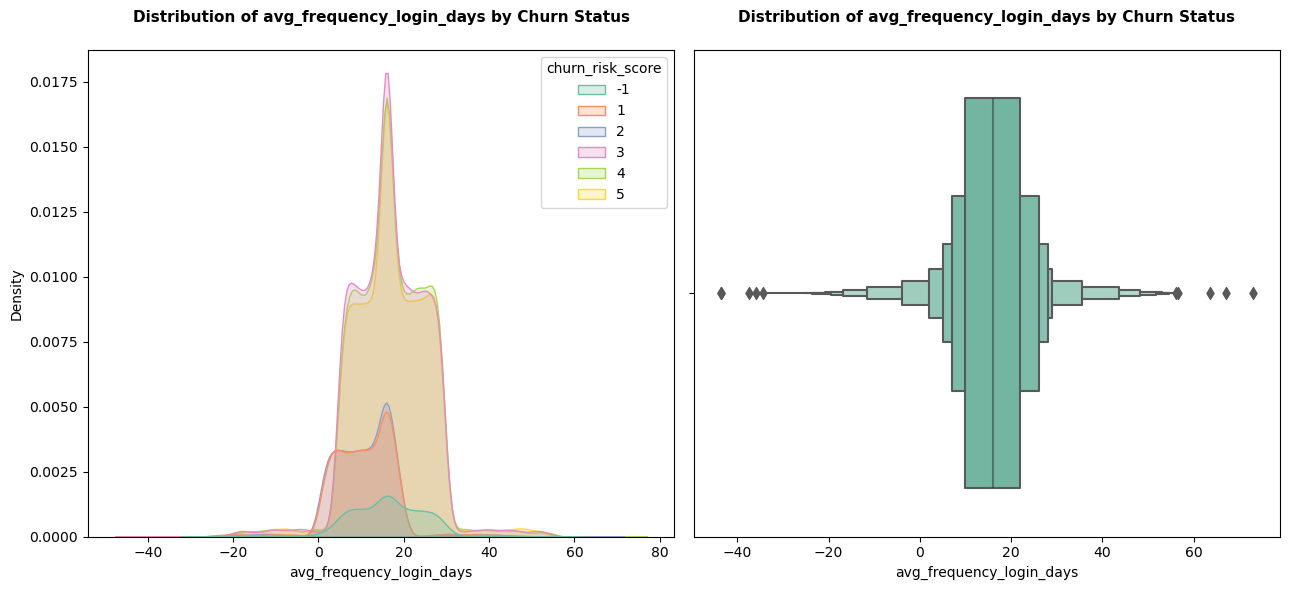

C:\Users\laito\AppData\Local\Temp\ipykernel_10780\1807629984.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)


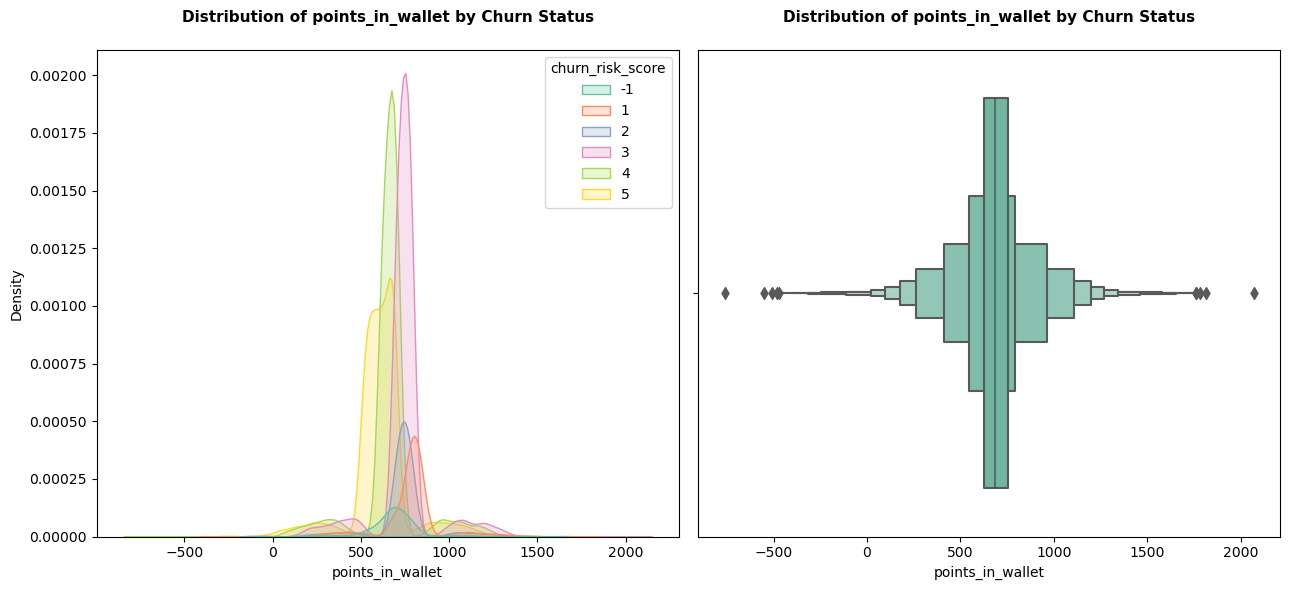

<Figure size 640x480 with 0 Axes>

In [84]:
for column in numerical_cols[:-1]:
  numerical_plot(column, df)
plt.tight_layout(pad=1.0)

# **Feature Engineering**

In [53]:
categorical_cols

['gender',
 'region_category',
 'membership_category',
 'joined_through_referral',
 'preferred_offer_types',
 'medium_of_operation',
 'internet_option',
 'used_special_discount',
 'offer_application_preference',
 'past_complaint',
 'complaint_status',
 'feedback']

In [74]:
t = 'feedback'
print(Counter(df[t]))

Counter({'Poor Product Quality': 6350, 'No reason specified': 6290, 'Too many ads': 6279, 'Poor Website': 6271, 'Poor Customer Service': 6252, 'Reasonable Price': 1417, 'User Friendly Website': 1391, 'Products always in Stock': 1382, 'Quality Customer Care': 1360})


In [58]:
print(Counter(df['medium_of_operation']))

Counter({'Desktop': 13913, 'Smartphone': 13876, '?': 5393, 'Both': 3810})


In [59]:
df['medium_of_operation']

0                 ?
1           Desktop
2           Desktop
3           Desktop
4        Smartphone
            ...    
36987       Desktop
36988    Smartphone
36989       Desktop
36990    Smartphone
36991       Desktop
Name: medium_of_operation, Length: 36992, dtype: object

In [85]:
def convert_categorical_to_numerical(df, col):
  df[col] = df[col].astype("category").cat.codes
  
def apply_feature_engineering(df):
    # Todo: Normalize your data
    for feature in categorical_cols:
        convert_categorical_to_numerical(df, feature)
    return df


df = apply_feature_engineering(df)


<AxesSubplot:>

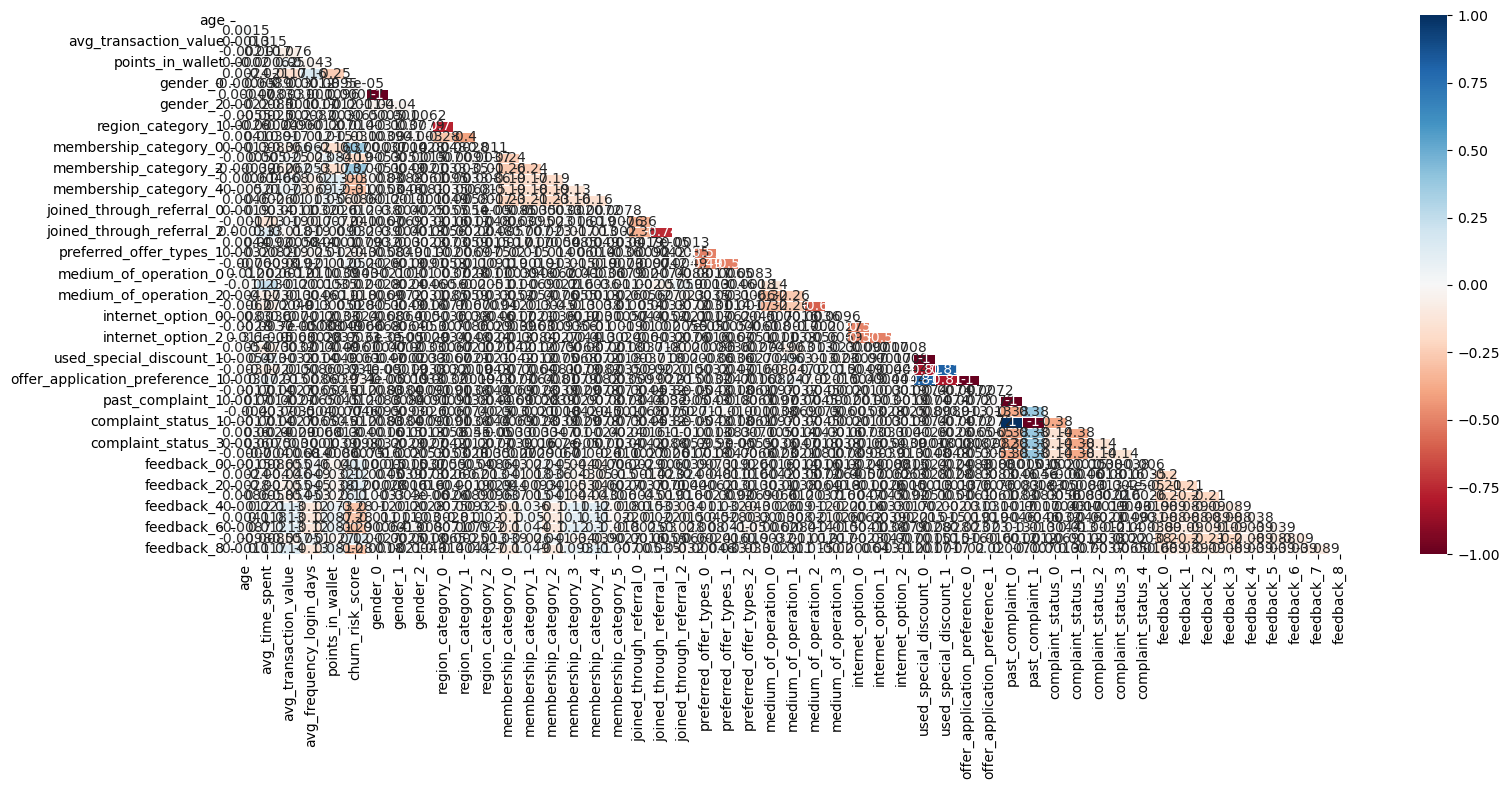

In [98]:
# Show heatmap after normalized data
corr = df.corr()
plt.figure(figsize = (18, 7))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask=mask,cmap='RdBu', vmin=-1, vmax= 1 , center=0, annot=True,linewidth=0.5)

<AxesSubplot:title={'center':'Correlation Between Target based on All Features'}>

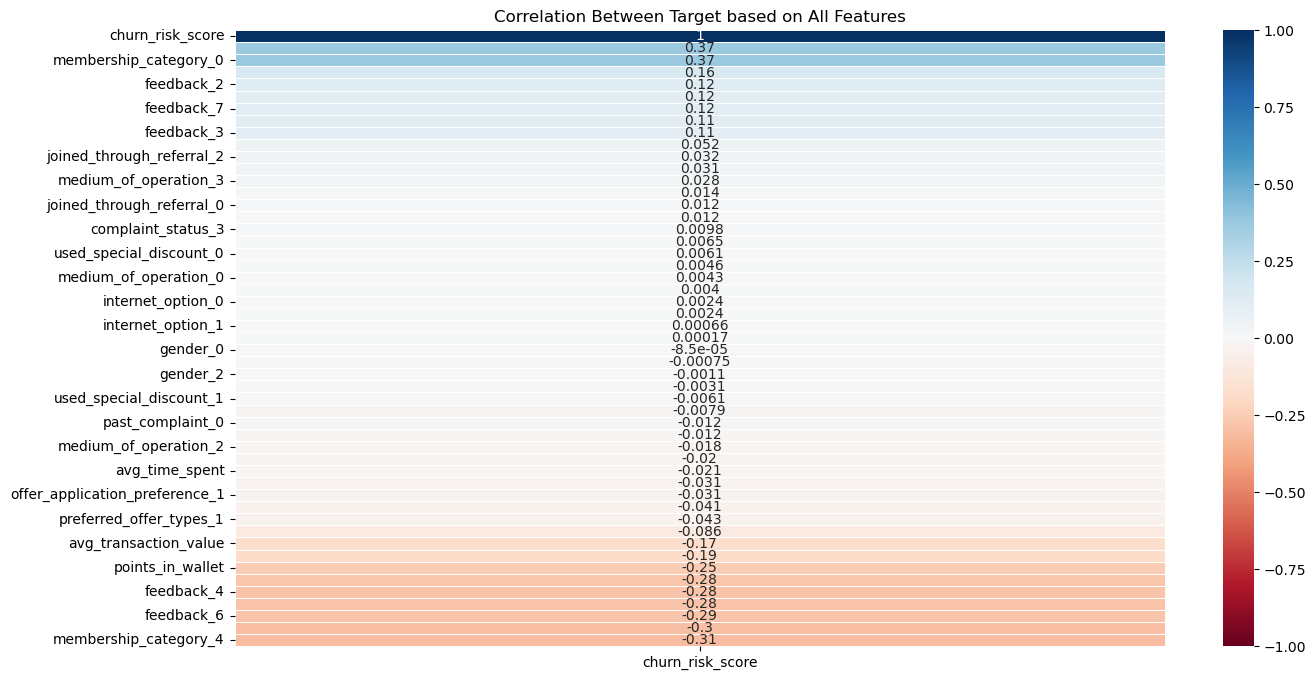

In [96]:
plt.figure(figsize=(15,8))
plt.title('Correlation Between Target based on All Features')
sns.heatmap(df.corr()[['churn_risk_score']].sort_values(by='churn_risk_score', ascending=False),cmap='RdBu', vmin=-1, vmax= 1 , center=0, annot=True,linewidth=.5,square=False)

In [97]:
# One Hot Encoding on Categorical Features
df = pd.get_dummies(columns=categorical_cols, data=df)

KeyError: "None of [Index(['gender', 'region_category', 'membership_category',\n       'joined_through_referral', 'preferred_offer_types',\n       'medium_of_operation', 'internet_option', 'used_special_discount',\n       'offer_application_preference', 'past_complaint', 'complaint_status',\n       'feedback'],\n      dtype='object')] are in the [columns]"

In [89]:
# Checking skewness of numerical features
df[numerical_cols].skew().to_frame().rename(columns={0:"Feature Skewness"})

,Feature Skewness
age,-0.007319
avg_time_spent,0.539624
avg_transaction_value,1.011027
avg_frequency_login_days,0.006063
points_in_wallet,-0.084329
churn_risk_score,-1.114305


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font>📊 Note:</font></h3>

    
* `avg_transaction_value` is highly right-skewed, which conveys that there is presence of **positive outliers**
* The same thing comes to `avg_time_spent`

In [90]:
avg_time_spent_save = df['avg_time_spent']
avg_transaction_value_save = df['avg_transaction_value']

In [91]:
# df['avg_time_spent'] = np.log(df['avg_time_spent'])
df['avg_transaction_value'] = np.log(df['avg_transaction_value'])

In [92]:
df.isnull().sum()

age                               0
avg_time_spent                    0
avg_transaction_value             0
avg_frequency_login_days          0
points_in_wallet                  0
churn_risk_score                  0
gender_0                          0
gender_1                          0
gender_2                          0
region_category_0                 0
region_category_1                 0
region_category_2                 0
membership_category_0             0
membership_category_1             0
membership_category_2             0
membership_category_3             0
membership_category_4             0
membership_category_5             0
joined_through_referral_0         0
joined_through_referral_1         0
joined_through_referral_2         0
preferred_offer_types_0           0
preferred_offer_types_1           0
preferred_offer_types_2           0
medium_of_operation_0             0
medium_of_operation_1             0
medium_of_operation_2             0
medium_of_operation_3       

## **Visualizing Transformation.**

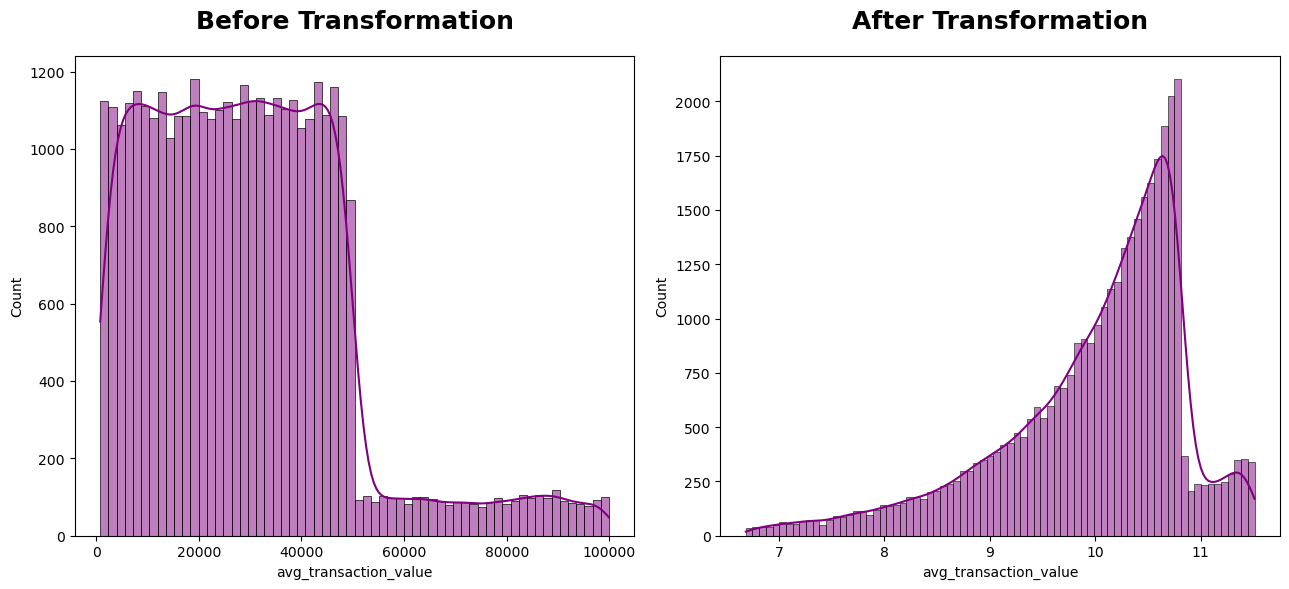

In [95]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
sns.histplot(avg_transaction_value_save, color="purple", kde=True)
plt.title("Before Transformation",fontweight="black",size=18,pad=20)

plt.subplot(1,2,2)
sns.histplot(df['avg_transaction_value'], color="purple", kde=True)
plt.title("After Transformation",fontweight="black",size=18,pad=20)
plt.tight_layout()
plt.show()

# **Model Training**

In [99]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# build model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GridSearchCV

# Dimentional Reduction
from sklearn. decomposition import PCA

# build pipeline
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

In [100]:
def prepare_X_y(df):
    X = df.drop('churn_risk_score', axis = 1).values
    y = df['churn_risk_score'].values
    return X, y

X, y = prepare_X_y(df)

In [101]:
RANDOM_STATE = 7
TRAIN_SIZE = 0.7

trainX, testX ,trainY, testY = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

> Built a Predictive Model to find the key factors that are significantly influencing customers churn rate score

## *Sampling Data*

In [102]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# # Randomly over sample the minority class
# smote = SMOTE(random_state=42)
# trainX_smote, trainY_smote = smote.fit_resample(trainX, trainY)

# # Check the number of records after over sampling
# print(sorted(Counter(trainY_smote).items()))

In [104]:
# for sampler_name, sampler in samplers.items():
#   print(sampler_name, sampler)

Random Oversampling RandomOverSampler()
SMOTE SMOTE()
Random Undersampling RandomUnderSampler()


<div class="list-group" id="list-tab" role="tablist">
    <h3 style="text-align: left; background-color: #ACA224; font-family:Tahoma; color: white; padding: 14px; line-height: 1; border-radius:10px"><b>BASELINE MODEL 📝</b></h3>

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Define the model
model = LogisticRegression()

# Define the different sampling techniques
samplers = {
    'Random Oversampling': RandomOverSampler(),
    'SMOTE': SMOTE(),
    'Random Undersampling': RandomUnderSampler()
}

# Perform cross-validation and evaluate the accuracy for each sampling technique
for sampler_name, sampler in samplers.items():
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')
    print(f"{sampler_name}: Accuracy = {scores.mean():.4f}")

Random Oversampling: Accuracy = 0.3663
SMOTE: Accuracy = 0.3461
Random Undersampling: Accuracy = 0.3480


In [ ]:
pip = Pipeline([
	('classifier', DecisionTreeClassifier())
])